Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomRotation,RandomZoom, RandomFlip, RandomTranslation
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomRotation,RandomZoom, RandomFlip, RandomTranslation
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

# Setting path to google drive location of images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# Checking total count of images in train and test directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2253
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),label_mode='categorical',
                                                               batch_size=batch_size,validation_split=0.2,
                                                               subset='training',seed=123)
train_ds

Found 2253 files belonging to 9 classes.
Using 1803 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),label_mode='categorical',
                                                               batch_size=batch_size,validation_split=0.2,
                                                               subset='validation',seed=123)
val_ds

Found 2253 files belonging to 9 classes.
Using 450 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2253 files belonging to 9 classes.


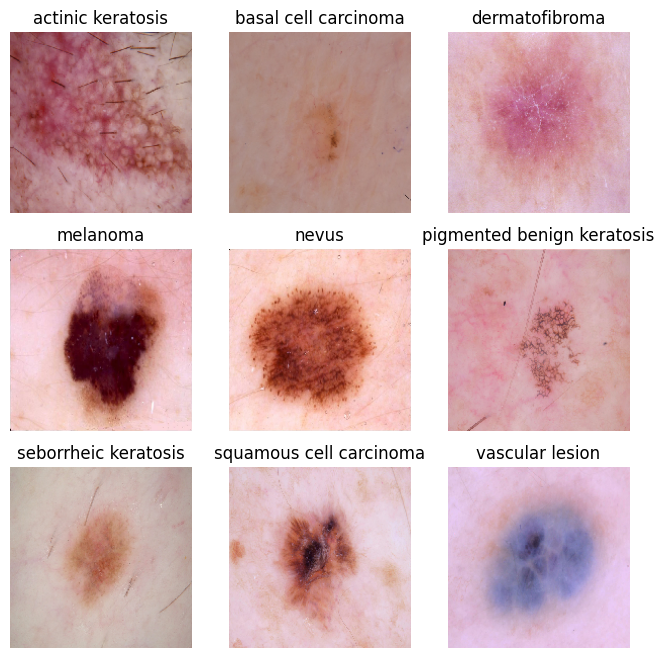

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
#Visualize one instance of all the class present in the dataset.

# Creating a image dataset to use for visualization
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

# Getting all classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

# Looping to create complete path for images
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(8,8)) # setting figsize
index = 0 # Initiating index for subplot position
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_width,img_height)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = len(class_names)

model1 = tf.keras.Sequential([
    # Rescaling Layer
    Rescaling(scale=1./255,input_shape = (img_height,img_width,3)),

    # First Convolution layer
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    # Second Convolution layer
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    # Third Convolution layer
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    #Flatten layer to convert multidimension tensor into single dimension
    Flatten(),

    #Dense Layer
    Dense(128, activation='relu'),

    #Dense Layer with softmax activation function.
    Dense(num_classes,activation='softmax')
  ])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function

#compiling model with 'adam' as optimizer and 'categorical_crossentropy' as loss function
model1.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# checking the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
# Training model1 with 20 epochs
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 68s 923ms/step - loss: 2.1412 - accuracy: 0.2357 - val_loss: 1.9651 - val_accuracy: 0.3244
Epoch 2/20
57/57 [==============================] - 48s 839ms/step - loss: 1.7624 - accuracy: 0.3694 - val_loss: 1.6238 - val_accuracy: 0.4178
Epoch 3/20
57/57 [==============================] - 46s 811ms/step - loss: 1.5421 - accuracy: 0.4587 - val_loss: 1.5793 - val_accuracy: 0.4622
Epoch 4/20
57/57 [==============================] - 45s 793ms/step - loss: 1.4270 - accuracy: 0.5086 - val_loss: 1.6821 - val_accuracy: 0.4022
Epoch 5/20
57/57 [==============================] - 45s 795ms/step - loss: 1.3485 - accuracy: 0.5286 - val_loss: 1.4134 - val_accuracy: 0.5044
Epoch 6/20
57/57 [==============================] - 46s 805ms/step - loss: 1.2661 - accuracy: 0.5585 - val_loss: 1.4949 - val_accuracy: 0.4667
Epoch 7/20
57/57 [==============================] - 46s 800ms/step - loss: 1.2274 - accuracy: 0.5718 - val_loss: 1.4203 - val_accuracy: 0.4889

### Visualizing training results

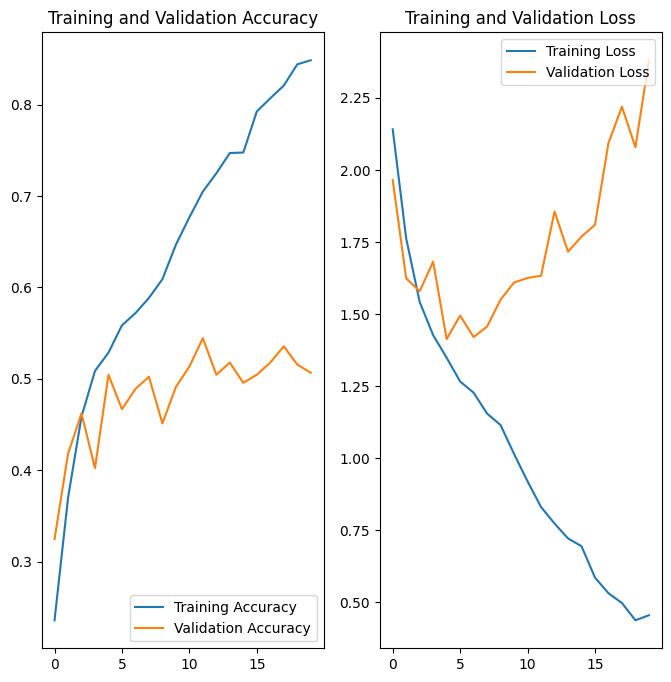

In [15]:
# visualization for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
- Model is overfitting and does not seem to learn much from training dataset
- From Training Vs Validation accuracy graph we can see that training accuracy is increasing with each epoch whereas validation accuracy has remained low


### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

#Data augumentation strategy.

rescale = Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  Rescaling(1./255)
])

data_augmentation = Sequential([
  #Randomly flip each image horizontally and vertically.
  RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  RandomRotation(0.2),

  #Randomly zoom each image during training.
  #RandomZoom(0.2),

  #Randomly zoom each image during training.
  RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3)),

  #Randomly translate each image during training.
  #layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

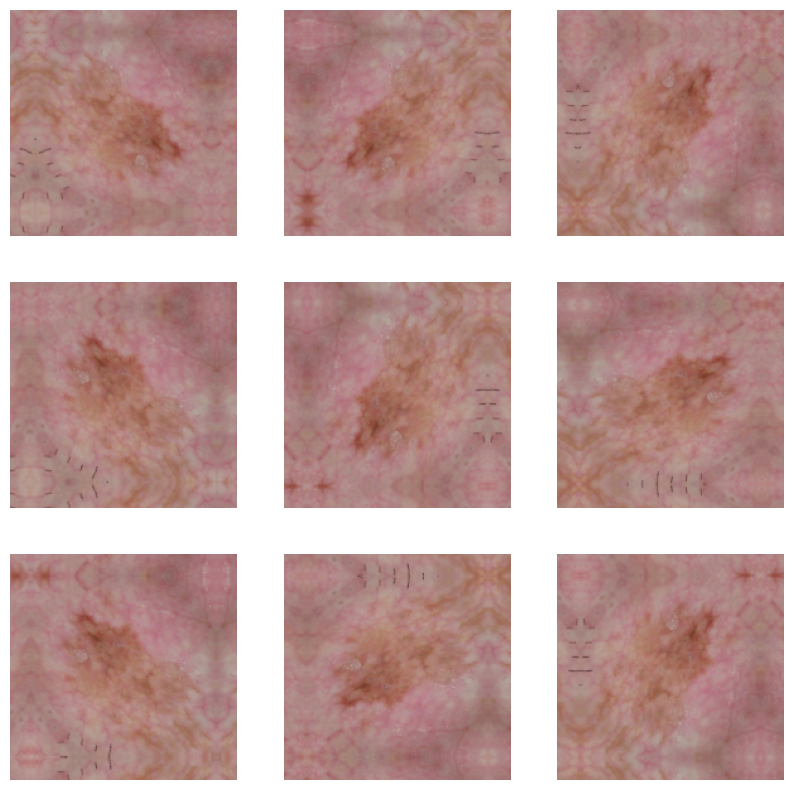

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = len(class_names)

model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(Conv2D(16,3,padding='same',activation='relu'))
model2.add(MaxPooling2D())

#Dropout layer with 10% Fraction of the input units to drop.
model2.add(Dropout(0.1))

#Second Convulation Layer
model2.add(Conv2D(32,3,padding='same',activation='relu'))
model2.add(MaxPooling2D())

#Dropout layer with 20% Fraction of the input units to drop.
#model2.add(layers.Dropout(0.20))

#Third Convulation Layer
model2.add(Conv2D(64,3,padding='same',activation='relu'))
model2.add(MaxPooling2D())

#Dropout layer with 20% Fraction of the input units to drop.
model2.add(Dropout(0.2))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(Flatten())

#Dense Layer
model2.add(Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model2.add(Dropout(0.3))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(Dense(num_classes,activation='softmax'))

### Compiling the model

In [19]:
## Your code goes here
#compiling model with 'adam' as optimizer and 'categorical_crossentropy' as loss function
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs

# Training model2 for 20 epochs
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
57/57 [==============================] - 61s 1s/step - loss: 2.1001 - accuracy: 0.2146 - val_loss: 1.9546 - val_accuracy: 0.3178
Epoch 2/20
57/57 [==============================] - 56s 983ms/step - loss: 1.9259 - accuracy: 0.2851 - val_loss: 1.8287 - val_accuracy: 0.3489
Epoch 3/20
57/57 [==============================] - 57s 998ms/step - loss: 1.8042 - accuracy: 0.3500 - val_loss: 1.7909 - val_accuracy: 0.3022
Epoch 4/20
57/57 [==============================] - 56s 984ms/step - loss: 1.6872 - accuracy: 0.3955 - val_loss: 1.6626 - val_accuracy: 0.3778
Epoch 5/20
57/57 [==============================] - 56s 991ms/step - loss: 1.7389 - accuracy: 0.3788 - val_loss: 1.6753 - val_accuracy: 0.3644
Epoch 6/20
57/57 [==============================] - 56s 981ms/step - loss: 1.6359 - accuracy: 0.4104 - val_loss: 1.5507 - val_accuracy: 0.4644
Epoch 7/20
57/57 [==============================] - 56s 981ms/step - loss: 1.5198 - accuracy: 0.4676 - val_loss: 1.6270 - val_accuracy: 0.4156
Ep

### Visualizing the results

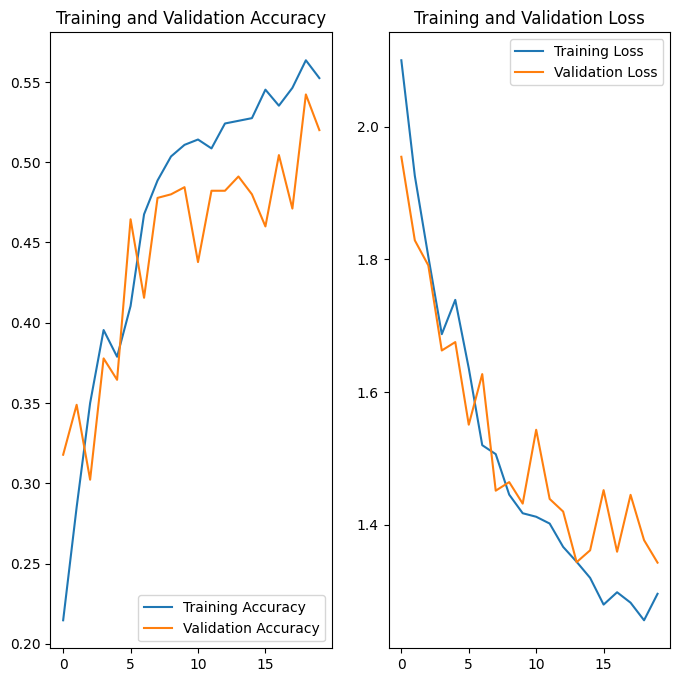

In [21]:
# visualization for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- After using drop out and augmentation overfitting issue is seems to be taken care of
- Model performance has not improved that much as both training and validation accuracy is in range of ~50% in most of epochs



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,melanoma,438
2,pigmented benign keratosis,470
3,dermatofibroma,96
4,nevus,357
5,squamous cell carcinoma,185
6,seborrheic keratosis,77
7,basal cell carcinoma,377
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

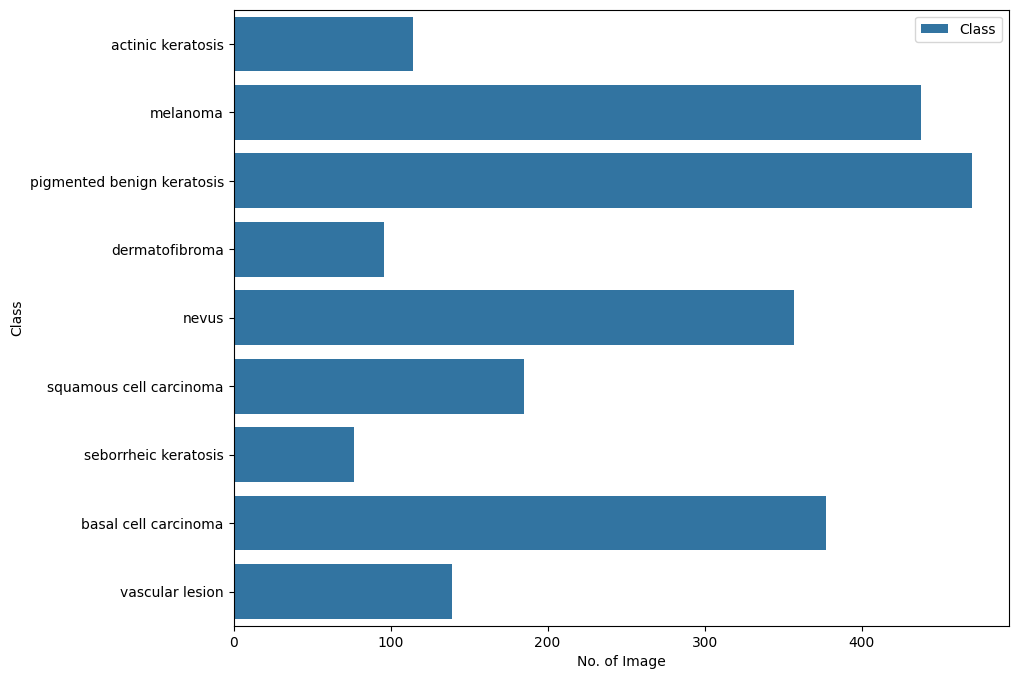

In [23]:
# plot to check class distribution
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

- seborrheic keratosis has the least number of samples (77 Samples).

#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis (470 Samples), melanoma (438 Samples), basal cell carcinoma (377 Samples), and nevus (357 Samples) classes dominates the data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E2C4576170>: 100%|██████████| 500/500 [00:06<00:00, 81.93 Samples/s]


Initialised with 377 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E5080D87C0>: 100%|██████████| 500/500 [00:05<00:00, 87.04 Samples/s] 


Initialised with 96 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78E3380826E0>: 100%|██████████| 500/500 [00:06<00:00, 80.49 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x78E4045542E0>: 100%|██████████| 500/500 [00:25<00:00, 19.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78E404233010>: 100%|██████████| 500/500 [00:23<00:00, 21.07 Samples/s]


Initialised with 470 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78E508074A30>: 100%|██████████| 500/500 [00:06<00:00, 83.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78E2BC783BE0>: 100%|██████████| 500/500 [00:12<00:00, 40.33 Samples/s]


Initialised with 185 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E308385180>: 100%|██████████| 500/500 [00:06<00:00, 81.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E308353C70>: 100%|██████████| 500/500 [00:06<00:00, 79.90 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [31]:
df2['Label'].value_counts()

,count
Label,
actinic keratosis,500
melanoma,500
pigmented benign keratosis,500
dermatofibroma,500
nevus,500
squamous cell carcinoma,500
seborrheic keratosis,500
basal cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
#data_dir_train="path to directory with training data + data created using augmentor"

data_dir_train="/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6753 files belonging to 9 classes.
Using 5403 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6753 files belonging to 9 classes.
Using 1350 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here
model3 = Sequential()                     #Sequential allows you to create models layer-by-layer

#model3.add(data_augmentation)             #Augmentation layer
model3.add(rescale)                       #Rescaling layer

#First Convulation Layer
model3.add(Conv2D(16,3,padding='same',activation='relu'))
model3.add(MaxPooling2D())

#Dropout layer with 10% Fraction of the input units to drop.
model3.add(layers.Dropout(0.1))

#Second Convulation Layer
model3.add(Conv2D(32,3,padding='same',activation='relu'))
model3.add(MaxPooling2D())

#Dropout layer with 20% Fraction of the input units to drop.
#model2.add(layers.Dropout(0.2))

#Third Convulation Layer
model3.add(Conv2D(64,3,padding='same',activation='relu'))
model3.add(MaxPooling2D())

#Dropout layer with 20% Fraction of the input units to drop.
model3.add(Dropout(0.2))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(Flatten())

#Dense Layer
#model3.add(Dense(256,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
#model3.add(Dropout(0.3))

#Dense Layer
model3.add(Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model3.add(Dropout(0.3))

#Adding batch normalization
model3.add(BatchNormalization())

#Dense Layer with softmax activation function.

#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here
#compiling model3 with 'adam' as optimizer and 'categorical_crossentropy' as loss function
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:

## Your code goes here, use 50 epochs.
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 [==============================] - 170s 992ms/step - loss: 1.8171 - accuracy: 0.3248 - val_loss: 1.6429 - val_accuracy: 0.3659
Epoch 2/50
169/169 [==============================] - 164s 968ms/step - loss: 1.4889 - accuracy: 0.4442 - val_loss: 1.8213 - val_accuracy: 0.3511
Epoch 3/50
169/169 [==============================] - 164s 963ms/step - loss: 1.3664 - accuracy: 0.4842 - val_loss: 1.3377 - val_accuracy: 0.4859
Epoch 4/50
169/169 [==============================] - 164s 966ms/step - loss: 1.2453 - accuracy: 0.5358 - val_loss: 1.2478 - val_accuracy: 0.5193
Epoch 5/50
169/169 [==============================] - 162s 951ms/step - loss: 1.1216 - accuracy: 0.5924 - val_loss: 1.1695 - val_accuracy: 0.5874
Epoch 6/50
169/169 [==============================] - 163s 963ms/step - loss: 1.0152 - accuracy: 0.6304 - val_loss: 1.0285 - val_accuracy: 0.6081
Epoch 7/50
169/169 [==============================] - 160s 943ms/step - loss: 0.9376 - accuracy: 0.6594 - val_loss: 1.0204 -

#### **Todo:**  Visualize the model results

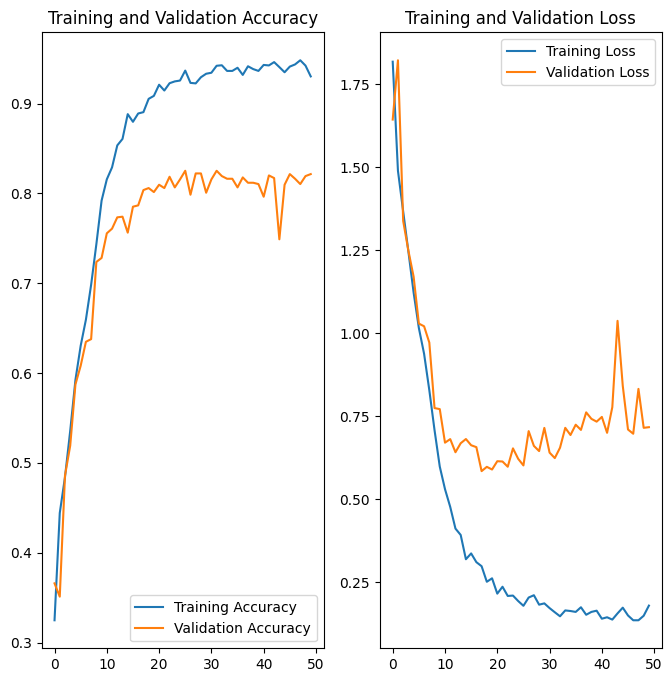

In [38]:
# visualization for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
 - After Class rebalance and augmentation model performance has improved
 - Final model (model 3) has given highest training and validation accuracy  .
 - Model overfitting issue is solved.
